# The SPEXone L1C data

## Summary
In this notebook we take a closer look at the SPEXone L1C data. This data set shows what the SPEXone instrument sees after calibration.

## Learning objectives

- explore the radiance for different sensor view angles and scenes
- explore the DoLP for different sensor view angles and scenes
- how to create meaningful RGB images

## Content

1. [Radiance plot](#Radiance-plot)
2. [DoLP plot](#DoLP-plot)
3. [RGB plot](#RGB-plot)


# Setup

Run the following cell to import the required python packages. The next cell will load the data we need.

In [1]:
import earthaccess
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from spexone_plotting import spexone_rad_to_modis

We use similar code to the one presented in the first tutorial to open the data. However, this time we point to an earlier downloaded data file to speed things up a bit.

In [2]:
path = "./data/PACE_SPEXONE.20250623T050948.L1C.V3.5km.nc"
prod = xr.open_dataset(path, engine="h5netcdf")
view = xr.open_dataset(path, group="sensor_views_bands").set_coords(["sensor_view_angle", "intensity_wavelength", "polarization_wavelength"])
geo = xr.open_dataset(path, group="geolocation_data").set_coords(["longitude", "latitude"])
obs = xr.open_dataset(path, group="observation_data").squeeze()
dataset = xr.merge((prod, obs, view, geo))
dataset

<xarray.Dataset> Size: 450MB
Dimensions:                  (bins_along_track: 396, bins_across_track: 29,
                              number_of_views: 5,
                              intensity_bands_per_view: 400,
                              polarization_bands_per_view: 50)
Coordinates:
    sensor_view_angle        (number_of_views) float32 20B ...
    intensity_wavelength     (number_of_views, intensity_bands_per_view) float32 8kB ...
    polarization_wavelength  (number_of_views, polarization_bands_per_view) float32 1kB ...
    latitude                 (bins_along_track, bins_across_track) float32 46kB ...
    longitude                (bins_along_track, bins_across_track) float32 46kB ...
Dimensions without coordinates: bins_along_track, bins_across_track,
                                number_of_views, intensity_bands_per_view,
                                polarization_bands_per_view
Data variables: (12/31)
    number_of_observations   (bins_along_track, bins_across_track, number_of_views) float32 230kB ...
    qc                       (bins_along_track, bins_across_track, number_of_views, intensity_bands_per_view) float32 92MB ...
    i                        (bins_along_track, bins_across_track, number_of_views, intensity_bands_per_view) float32 92MB ...
    i_stdev                  (bins_along_track, bins_across_track, number_of_views, intensity_bands_per_view) float32 92MB ...
    qc_polsample             (bins_along_track, bins_across_track, number_of_views, polarization_bands_per_view) float32 11MB ...
    i_polsample              (bins_along_track, bins_across_track, number_of_views, polarization_bands_per_view) float32 11MB ...
    ...                       ...
    solar_zenith_angle       (bins_along_track, bins_across_track, number_of_views) float32 230kB ...
    solar_azimuth_angle      (bins_along_track, bins_across_track, number_of_views) float32 230kB ...
    sensor_zenith_angle      (bins_along_track, bins_across_track, number_of_views) float32 230kB ...
    sensor_azimuth_angle     (bins_along_track, bins_across_track, number_of_views) float32 230kB ...
    scattering_angle         (bins_along_track, bins_across_track, number_of_views) float32 230kB ...
    rotation_angle           (bins_along_track, bins_across_track, number_of_views) float32 230kB ...
Attributes: (12/40)
    Conventions:                       CF-1.10 ACDD-1.3
    institution:                       NASA Goddard Space Flight Center, Ocea...
    instrument:                        SPEXone
    software_version:                  3.12.1
    product_name:                      PACE_SPEXONE.20250623T050948.L1C.V3.5k...
    project:                           PACE Project
    ...                                ...
    geospatial_lon_min:                116.909096
    geospatial_lon_max:                122.42104
    history:                           /home/sdpsoper/Science/OCSSW/DEVEL/bin...
    processing_version:                3
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/SPEXONE/L1C/SCI/3

# Radiance plot

Next we plot the 5 viewports in for a given wavelength. Try to understand the plotting script below:

/opt/homebrew/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


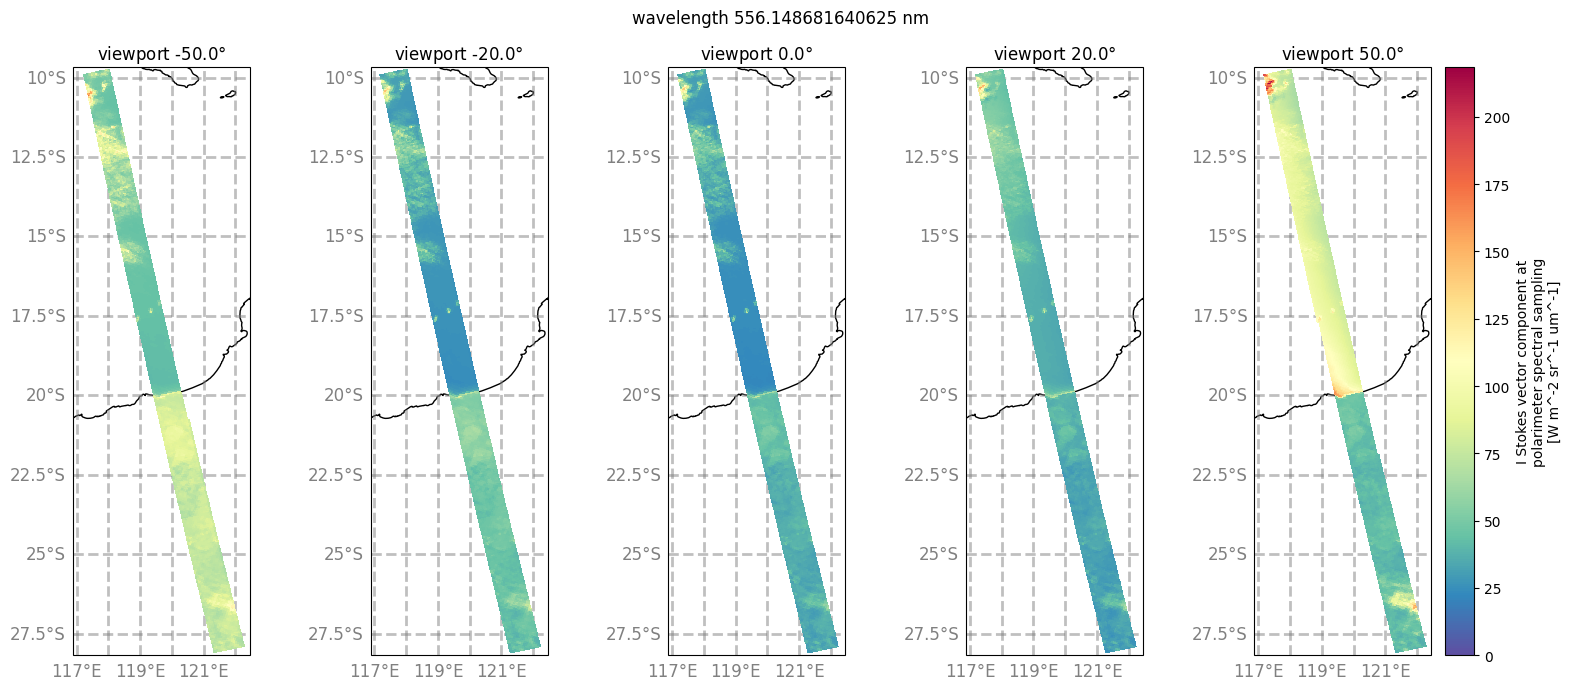

In [4]:
fig = plt.figure(figsize=(16, 7))
grid = plt.GridSpec(1, 5, figure=fig)
projection = ccrs.PlateCarree()
cmap = "Spectral_r"

def get_closest_wavelength_band(desired_wav, available_wavelengths):
    return np.argmin(np.abs(available_wavelengths - desired_wav))

def get_closest_wavelength(desired_wav, available_wavelengths):
    band = get_closest_wavelength_band(desired_wav, available_wavelengths)
    return dataset["polarization_wavelength"].values[0, band]

desired_wav = 560  # nm, wavelength for which we want to plot the different viewport
available_wavelengths = dataset["polarization_wavelength"].values[0, :]
wav = get_closest_wavelength(desired_wav, available_wavelengths)
band = get_closest_wavelength_band(desired_wav, available_wavelengths)

fig.suptitle(f"wavelength {wav} nm")

vmax = np.nanmax(dataset["i_polsample"].sel({"polarization_bands_per_view": band}).values)
for vp in range(5):
    ax = fig.add_subplot(grid[vp], projection=projection)
    ax.coastlines()
    dataset["i_polsample"].sel({"number_of_views": vp, "polarization_bands_per_view": band}).plot(x="longitude", y="latitude", vmin=0, vmax=vmax, add_colorbar=(vp == 4), cmap=cmap, zorder=5, rasterized=True)
    ax.set_title(f'viewport {dataset["sensor_view_angle"][vp].values}' + r"$\degree$")

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels={"left": "y", "bottom": "x"},
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
fig.subplots_adjust(left=0.1, right=1 - 0.1)
plt.tight_layout()

Now change the wavelength for which the plot is made. How can you do that?  What is the smallest wavelength available? What is the largest? Can you find anything interesting in this data? What are the black lines in the plots?

# DoLP plot

Next you update the plot above such that degree of linear polarization ('dolp') is plotted instead of i_polsample. Have a look at the data, do you see anything interesting?

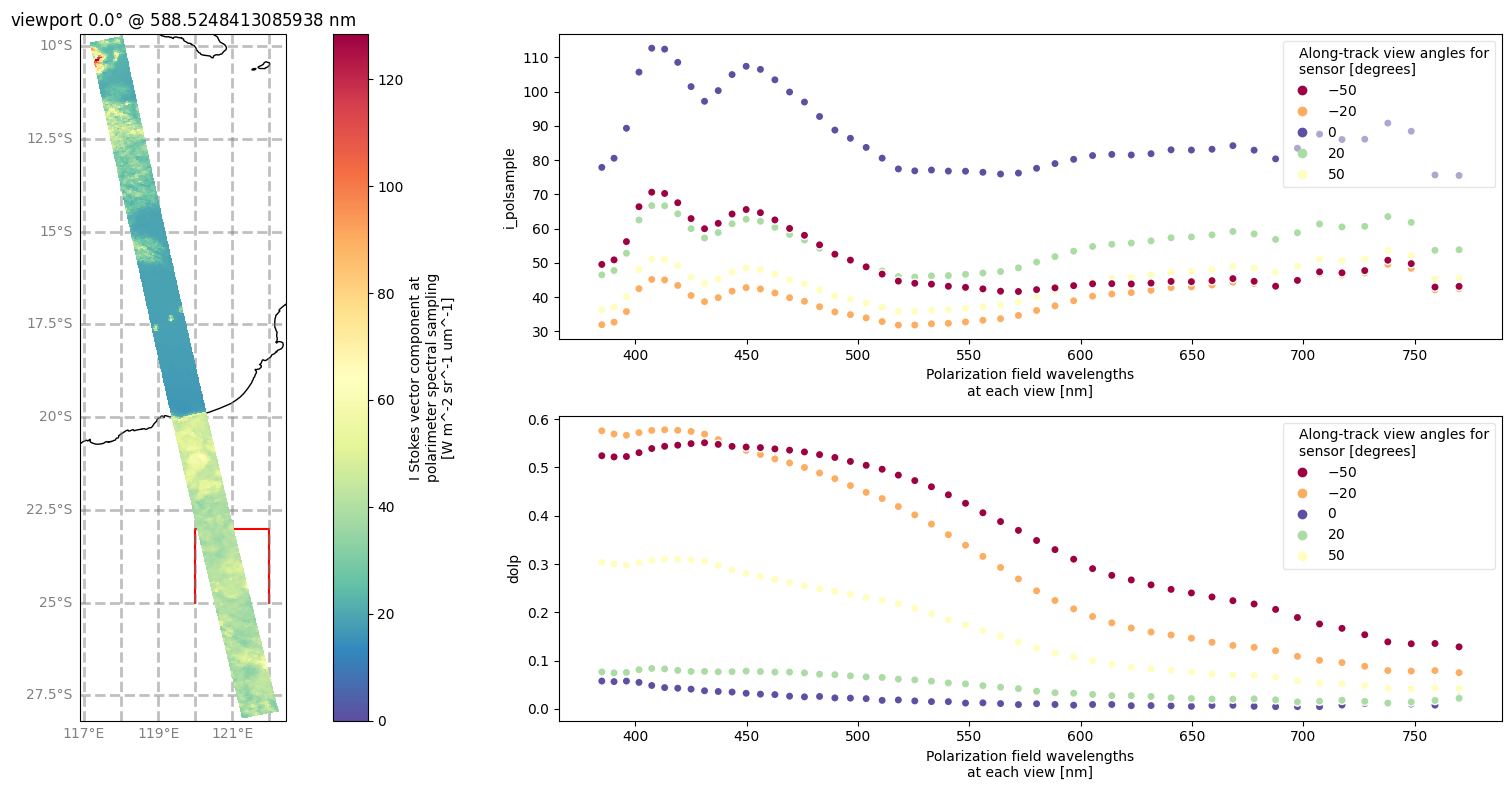

In [6]:
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(2, 2, figure=fig)
projection = ccrs.PlateCarree()

# define the longitude latitude box for which we want to plot the pixel values
longitude_min = 120
longitude_max = 122
latitude_min = -25
latitude_max = -23

# nadir view
ax = fig.add_subplot(grid[:, 0], projection=projection)
ax.coastlines()
dataset["i_polsample"].sel({"number_of_views": 2, "polarization_bands_per_view": 30}).plot(x="longitude", y="latitude", vmin=0, cmap=cmap, zorder=5, rasterized=True)
ax.set_title(
    f'viewport {dataset["sensor_view_angle"][2].values}' 
    + r"$\degree$" 
    + f' @ {dataset["polarization_wavelength"][2, 30].values} nm'
)
ax.plot(
    [longitude_min, longitude_min, longitude_max, longitude_max],
    [latitude_min, latitude_max, latitude_max, latitude_min],
    "r-"
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels={"left": "y", "bottom": "x"}, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}

# radiance plot
ax = fig.add_subplot(grid[0, 1])
_ = dataset["i_polsample"].where(
    (
        (dataset["latitude"] > latitude_min) 
        & (dataset["latitude"] < latitude_max) 
        & (dataset["longitude"] > longitude_min) 
        & (dataset["longitude"] < longitude_max)
), drop=True).mean(dim=["bins_along_track", "bins_across_track"]).plot.scatter(x="polarization_wavelength", y="i_polsample", hue="sensor_view_angle", cmap=cmap, add_legend=True, add_colorbar=False)

# dolp plot
ax = fig.add_subplot(grid[1, 1])
_ = dataset["dolp"].where(
    (
        (dataset["latitude"] > latitude_min) 
        & (dataset["latitude"] < latitude_max) 
        & (dataset["longitude"] > longitude_min) 
        & (dataset["longitude"] < longitude_max)
), drop=True).mean(dim=["bins_along_track", "bins_across_track"]).plot.scatter(x="polarization_wavelength", y="i_polsample", hue="sensor_view_angle", cmap=cmap, add_legend=True, add_colorbar=False)

plt.tight_layout()

Above you see the nadir viewport of our data set and the radiance and dolp spectra. Analyze the data, can you find out how the spectra differ for clouds, water and land among the different viewports?

# RGB plot

Finally we will plot the scene in RGB. First we do it in a very simple way, using a red, a green and a blue band from the SPEXone data with some arbitrary scaling:

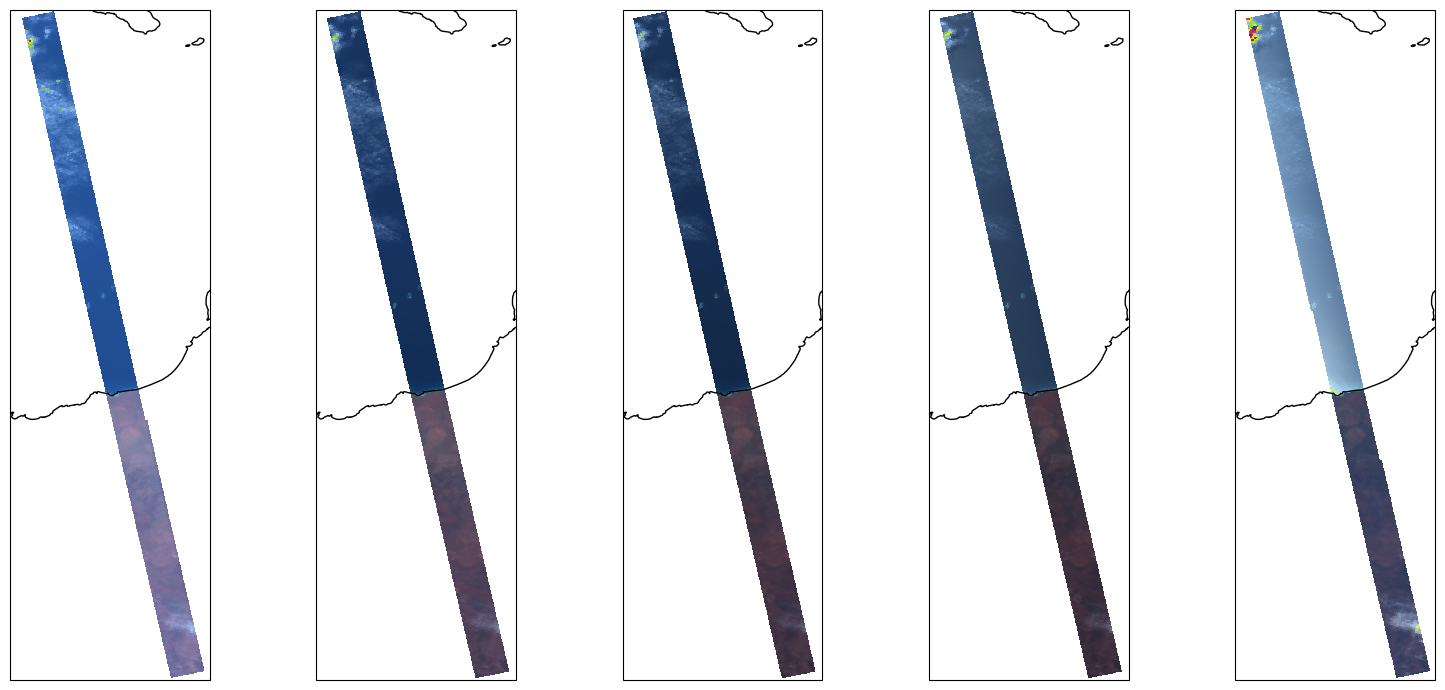

In [7]:
fig = plt.figure(figsize=(16, 7))
grid = plt.GridSpec(1, 5, figure=fig)

available_wavelengths = dataset["polarization_wavelength"].values[0, :]

for vp in range(5):
    longitude = dataset["longitude"].values
    latitude = dataset["latitude"].values
    red = dataset["i_polsample"].where(
        (dataset["polarization_wavelength"] == get_closest_wavelength(630.0, available_wavelengths))
        & (dataset["sensor_view_angle"] == dataset["sensor_view_angle"][vp]), drop=True
    ).squeeze().values
    green = dataset["i_polsample"].where(
        (dataset["polarization_wavelength"] == get_closest_wavelength(532.0, available_wavelengths))
        & (dataset["sensor_view_angle"] == dataset["sensor_view_angle"][vp]), drop=True
    ).squeeze().values
    blue = dataset["i_polsample"].where(
        (dataset["polarization_wavelength"] == get_closest_wavelength(465.0, available_wavelengths))
        & (dataset["sensor_view_angle"] == dataset["sensor_view_angle"][vp]), drop=True
    ).squeeze().values
    rgb = np.dstack((red / 170, green / 170, blue / 170))  # arbitrary scaling

    projection = ccrs.Orthographic(central_longitude=np.median(longitude))
    data_crs = ccrs.PlateCarree()
    
    ax = fig.add_subplot(grid[vp], projection=projection)
    ax.coastlines()
    ax.pcolormesh(longitude, latitude, rgb, transform=data_crs)

plt.tight_layout()

We have prepared a more sofisticated plotting function. By looking at the images above and the images below: what do you think is taken into account in the spexone_rad_to_modis function?

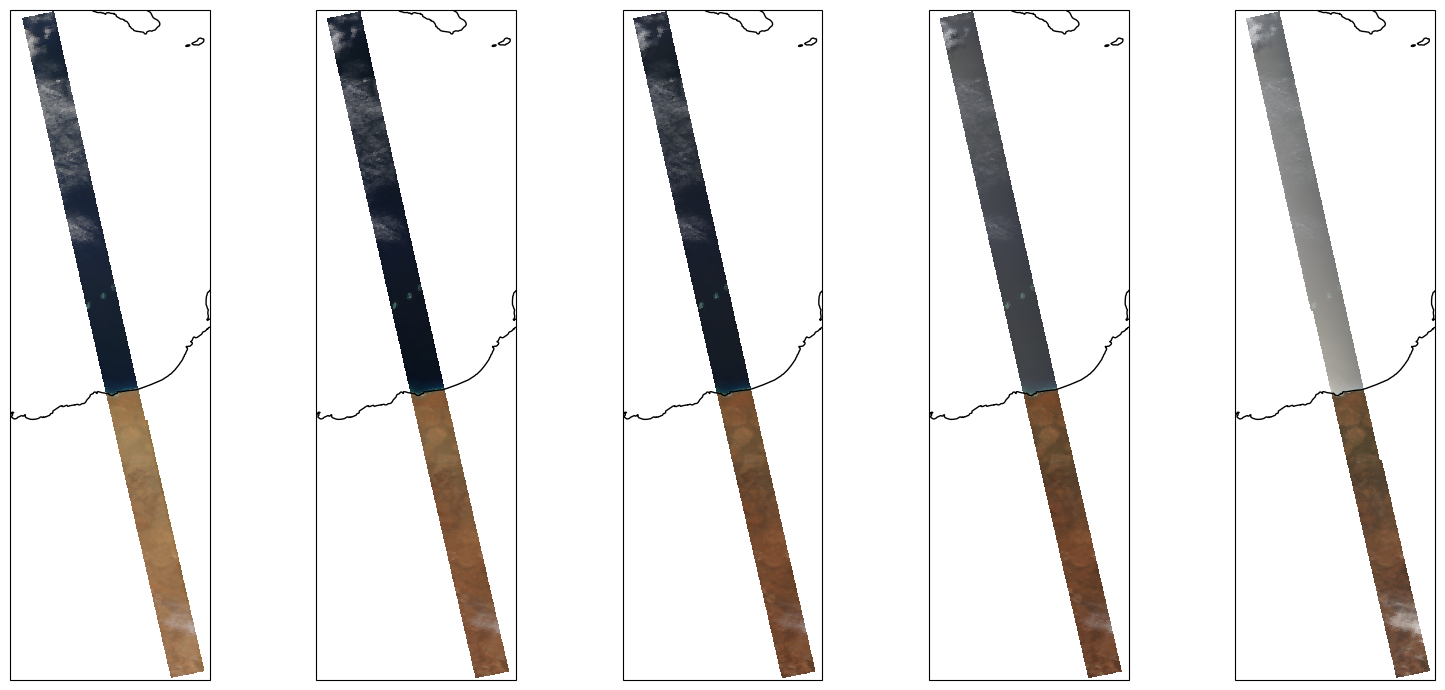

In [8]:
new_dataset = spexone_rad_to_modis(dataset)
new_dataset["rgb"].where(new_dataset["sensor_view_angle"] == 0, drop=True).squeeze()

fig = plt.figure(figsize=(16, 7))
grid = plt.GridSpec(1, 5, figure=fig)

for vp in range(5):
    longitude = new_dataset["longitude"].values
    latitude = new_dataset["latitude"].values
    rgb = new_dataset["rgb"].where(new_dataset["sensor_view_angle"] == new_dataset["sensor_view_angle"][vp], drop=True).squeeze().values

    projection = ccrs.Orthographic(central_longitude=np.median(longitude))
    data_crs = ccrs.PlateCarree()
    
    ax = fig.add_subplot(grid[vp], projection=projection)
    ax.coastlines()
    ax.pcolormesh(longitude, latitude, rgb, transform=data_crs)

plt.tight_layout()

Come up with your own RGB plot: can you find a combination of DoLP, intensity, and wavelengths that emphasizes some feature(s) of interest in your preselected L1C products?

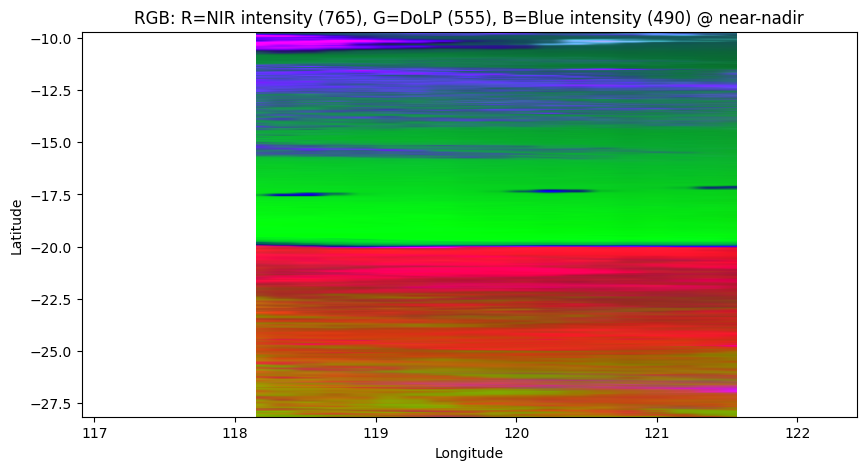

In [ ]:
# Bring out coastal areas more

def get_closest_wavelength_band(desired_wav, available_wavelengths):
    return int(np.argmin(np.abs(available_wavelengths - desired_wav)))

def get_closest_wavelength(desired_wav, available_wavelengths):
    return available_wavelengths[get_closest_wavelength_band(desired_wav, available_wavelengths)]

available_wavelengths = dataset["polarization_wavelength"].values[0, :]
vp = int(np.argmin(np.abs(dataset["sensor_view_angle"].values)))  # near-nadir

def sel(varname, wl_nm):
    target = get_closest_wavelength(wl_nm, available_wavelengths)
    return dataset[varname].where(
        (dataset["polarization_wavelength"] == target) &
        (dataset["sensor_view_angle"] == dataset["sensor_view_angle"][vp]),
        drop=True
    ).squeeze().values

def norm(a, pmin=2, pmax=98):
    lo, hi = np.nanpercentile(a, [pmin, pmax])
    return np.clip((a - lo) / (hi - lo + 1e-6), 0, 1)

I_nir = sel("i_polsample", 765.0)
D_green = sel("dolp", 555.0)
I_blue = sel("i_polsample", 490.0)

rgb = np.dstack([norm(I_nir), norm(D_green), norm(I_blue)])

lon = dataset["longitude"].values
lat = dataset["latitude"].values
plt.figure(figsize=(10, 5))
plt.imshow(rgb, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
           origin="lower", aspect="auto")
plt.title("RGB: R=NIR intensity (765), G=DoLP (555), B=Blue intensity (490) @ near-nadir")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()

Available view angles: [-50. -20.   0.  20.  50.]


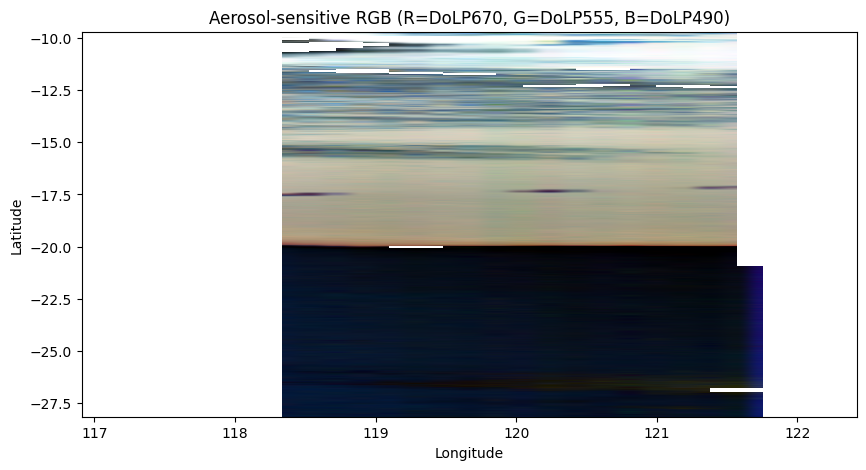

In [20]:
# Detect aerosol plumes

angles = dataset["sensor_view_angle"].values
print("Available view angles:", angles)

# Choose viewport (set one of the following)
# vp_idx = 0      # one extreme (if there are 5 views: 0..4)
# vp_idx = 4      # the other extreme
vp_idx = int(np.argmax(np.abs(angles)))  # default: off-nadir extreme to boost polarization contrast

def get_closest_wavelength_band(desired_wav, available_wavelengths):
    return int(np.argmin(np.abs(available_wavelengths - desired_wav)))

def get_closest_wavelength(desired_wav, available_wavelengths):
    return available_wavelengths[get_closest_wavelength_band(desired_wav, available_wavelengths)]

def sel(varname, wl_nm, vp_idx):
    aw = dataset["polarization_wavelength"].values[0, :]
    target = get_closest_wavelength(wl_nm, aw)
    return dataset[varname].where(
        (dataset["polarization_wavelength"] == target) &
        (dataset["sensor_view_angle"] == dataset["sensor_view_angle"][vp_idx]),
        drop=True
    ).squeeze().values

def norm(a, pmin=2, pmax=98):
    lo, hi = np.nanpercentile(a, [pmin, pmax])
    return np.clip((a - lo) / (hi - lo + 1e-6), 0, 1)

# Tweakable contrast stretch
pmin, pmax = 1, 99  # try (2,98), (5,95), etc.

# DoLP channels
D490 = sel("dolp", 490.0, vp_idx)
D555 = sel("dolp", 555.0, vp_idx)
D670 = sel("dolp", 670.0, vp_idx)

# Simple cloud suppression (very bright pixels)
I555 = sel("i_polsample", 555.0, vp_idx)
cloud_mask = I555 > np.nanpercentile(I555, 99.5)
for A in (D490, D555, D670):
    A[cloud_mask] = np.nan

# Compose RGB: R=DoLP670, G=DoLP555, B=DoLP490
rgb = np.dstack([
    norm(D670, pmin, pmax),
    norm(D555, pmin, pmax),
    norm(D490, pmin, pmax),
])

lon = dataset["longitude"].values
lat = dataset["latitude"].values
plt.figure(figsize=(10, 5))
plt.imshow(rgb, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
           origin="lower", aspect="auto")
plt.title("Aerosol-sensitive RGB (R=DoLP670, G=DoLP555, B=DoLP490)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()